In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import urllib
import json
from urllib.parse import urlencode

plt.style.use('dark_background')

In [2]:
from datetime import datetime, timedelta

In [3]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/413464/RFM_ht_data.csv')
df

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


In [4]:
df.dtypes

InvoiceNo        object
CustomerCode     object
InvoiceDate      object
Amount          float64
dtype: object

In [5]:
df['InvoiceNo'] = df['InvoiceNo'].apply(str)
df['CustomerCode'] = df['CustomerCode'].apply(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
df.groupby('CustomerCode').agg({'InvoiceNo':'nunique'}).max()

InvoiceNo    204
dtype: int64

In [7]:
last_date = df['InvoiceDate'].max()
last_date

Timestamp('2020-09-30 00:00:00')

In [8]:
rfmTable = df.groupby('CustomerCode', as_index=False).agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': lambda x: len(x),      # Frequency #Количество заказов
                                        'Amount': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам
rfmTable

,CustomerCode,InvoiceDate,InvoiceNo,Amount
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


In [9]:
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)
rfmTable

,CustomerCode,recency,frequency,monetary_value
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


In [10]:
quantiles = rfmTable.quantile(q=[0.25, 0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [11]:
rfmSegmentation = rfmTable

In [12]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [13]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)\
+ rfmSegmentation.F_Quartile.map(str)\
+ rfmSegmentation.M_Quartile.map(str)

In [14]:
rfmSegmentation.head()

,CustomerCode,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443


In [15]:
rfmSegmentation.RFMClass.value_counts()

444    10624
111     9705
443     6729
344     6593
211     5847
       ...  
424       63
114       60
214       60
314       33
414        2
Name: RFMClass, Length: 64, dtype: int64

In [16]:
rfmSegmentation[rfmSegmentation['RFMClass']=='311'].shape[0]

1609

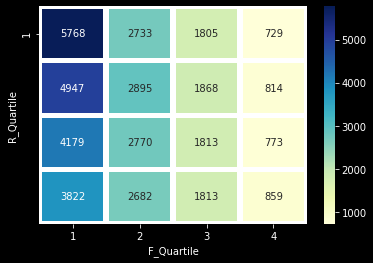

In [17]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);